# Flight Delay Prediction

In [1]:
#import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import math
import matplotlib.pyplot as plt

print("Libraries Imported.")

Libraries Imported.


In [ ]:
# todo
# remove outliers of flight delay
# try PCA to reduce dimensions

### Declare parameters for data transformation and modeling

In [78]:
categorical_cols = ['DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
continuous_cols = ['DEP_TIME', 'ARR_TIME']
target_col = 'ARR_DELAY'
sample_rate = .25
test_data_frac = .20

## Read in BTS Data

In [61]:
data_raw = pd.read_csv('2022-01-bts-ontime-reporting.csv') #",index_col=0)
print(data_raw.shape)

(537902, 39)


### Remove cancelled and diverted flights

In [62]:
data_raw = data_raw[data_raw.CANCELLED == 0]
data_raw = data_raw[data_raw.DIVERTED == 0]
print(data_raw.shape)

(503529, 39)


### Histogram of delay arrival

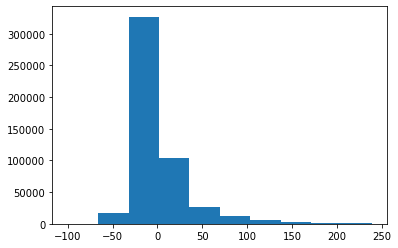

In [63]:
plt_data = data_raw[data_raw['ARR_DELAY']<240]
plt.hist(plt_data['ARR_DELAY'])
plt.show() 

### See unique value count of several input columns

In [64]:
print(data_raw.DEST_AIRPORT_ID.unique().size)
print(data_raw.DEST_CITY_MARKET_ID.unique().size)
print(data_raw.DEST.unique().size)
print(data_raw.OP_UNIQUE_CARRIER.unique().size)

363
339
363
17


### Sample data to subset rows

In [65]:
data_sampled = data_raw.sample(frac=sample_rate, random_state=42)
print(data_sampled.shape)

(125882, 39)


### Subset columns

In [66]:
all_cols = categorical_cols + continuous_cols + [target_col]
data_trimmed = data_sampled[all_cols]
print(data_trimmed.head(5))
print(data_trimmed.shape)

        DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN DEST  DEP_TIME  ARR_TIME  \
281970            1                DL    LGA  BNA     953.0    1108.0   
504162            7                AA    MIA  TPA     911.0    1009.0   
215774            4                F9    SWF  MIA    1202.0    1528.0   
237699            5                OO    SEA  MFR     935.0    1057.0   
97120             4                NK    DEN  FLL    1641.0    2232.0   

        ARR_DELAY  
281970      148.0  
504162      -10.0  
215774        9.0  
237699       -9.0  
97120        77.0  
(125882, 7)


### Check for null departure times and arrival times, create new flight time column

In [67]:
print(data_trimmed['DEP_TIME'].isnull().sum())
print(data_trimmed['ARR_TIME'].isnull().sum())
print(data_trimmed['ARR_DELAY'].isnull().sum())

0
0
0


In [69]:
#check for flight departing before midnite and landing after midnite
data_trimmed['FLIGHT_TIME'] = data_trimmed['FLIGHT_TIME'].apply(lambda x: x if x >= 0 else 2400 + x)
print(data_trimmed.head(5))
print(data_trimmed.shape)

        DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN DEST  DEP_TIME  ARR_TIME  \
281970            1                DL    LGA  BNA     953.0    1108.0   
504162            7                AA    MIA  TPA     911.0    1009.0   
215774            4                F9    SWF  MIA    1202.0    1528.0   
237699            5                OO    SEA  MFR     935.0    1057.0   
97120             4                NK    DEN  FLL    1641.0    2232.0   

        ARR_DELAY  FLIGHT_TIME  
281970      148.0        155.0  
504162      -10.0         98.0  
215774        9.0        326.0  
237699       -9.0        122.0  
97120        77.0        591.0  
(125882, 8)


C:\Users\joship\AppData\Local\Temp\ipykernel_23748\3739334324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_trimmed['FLIGHT_TIME'] = data_trimmed['FLIGHT_TIME'].apply(lambda x: x if x >= 0 else 2400 + x)


### Round times to hour amounts

In [49]:
#transform time columns to nearest hour
#data['DEP_TIME'] = round(data['DEP_TIME'] / 100)
#data['ARR_TIME'] = round(data['ARR_TIME'] / 100)
#print(data.head(10))

### Show descriptive statistics

In [80]:
data_trimmed.describe()

,DAY_OF_WEEK,DEP_TIME,ARR_TIME,ARR_DELAY,FLIGHT_TIME
count,125882.000000,125882.000000,125882.000000,125882.000000,125882.000000
mean,3.999460,1332.912331,1480.490491,4.120057,240.369823
std,2.076446,494.717073,525.709620,52.285135,186.821054
min,1.000000,1.000000,1.000000,-74.000000,0.000000
25%,2.000000,925.000000,1105.000000,-17.000000,124.000000
50%,4.000000,1326.000000,1515.000000,-8.000000,198.000000
75%,6.000000,1736.750000,1917.000000,7.000000,294.000000
max,7.000000,2400.000000,2400.000000,2080.000000,2399.000000


### Perform one hot encoding on categorical columns

In [75]:
data_encoded = pd.get_dummies(data_trimmed, columns = categorical_cols)
data_encoded = data_encoded.fillna(0)
print(data_encoded.shape)

(125882, 751)


## Split prepped data into train and test

In [79]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(data_encoded.drop(target_col,axis=1),data_encoded[target_col],test_size = test_data_frac)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)

(100705, 750)
(25177, 750)
(100705,)


### Linear Regression

In [89]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_valid)
#y_pred = y_pred.round()
mse = sklearn.metrics.mean_squared_error(y_valid, y_pred)
rmse = math.sqrt(mse)
print("Linear Regression RMSE", rmse)

Linear Regression RMSE 50.63702080727348


In [83]:
y_pred

array([ -4.94776917,  -8.14936447,  -6.73706436, ..., -11.23014069,
        -7.06900406,   5.26227951])

In [84]:
y_valid

377590    -7.0
246641    -8.0
145914   -27.0
434826    -7.0
51425     60.0
          ... 
308103     0.0
268014   -23.0
309514   -17.0
196556    -9.0
307611   -22.0
Name: ARR_DELAY, Length: 25177, dtype: float64

### Decision Tree Regressor

In [95]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model

regr = DecisionTreeRegressor(max_depth=5)
regr.fit(x_train, y_train)

# Predict
y_pred_dt = regr.predict(x_valid)
mse = sklearn.metrics.mean_squared_error(y_valid, y_pred_dt)
rmse = math.sqrt(mse)
print("Decision Tree RMSE", rmse)

Decision Tree RMSE 49.98316076005113


### Random Forest Regression

In [96]:
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 300, random_state = 0, max_features=40)
  
# fit the regressor with x and y data
regressor.fit(x_train, y_train) 
# validate model
y_pred_rf = regressor.predict(x_valid)
mse = sklearn.metrics.mean_squared_error(y_valid, y_pred_rf)
rmse = math.sqrt(mse)
print("Random Forest Regression RMSE", rmse)

Random Forest Regression RMSE 48.26004884052771


### Gradient Boosting Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(x_train, y_train)

y_pred_gb = reg.predict(x_test)
mse = sklearn.metrics.mean_squared_error(y_valid, y_pred_gb)
rmse = math.sqrt(mse)
print("Gradient Boosting Regression RMSE", rmse)

### Neural Network Regression

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

regr = MLPRegressor(random_state=1, max_iter=600).fit(x_train, y_train)
y_pred_nn = regr.predict(x_valid)
mse = sklearn.metrics.mean_squared_error(y_valid, y_pred_nn)
rmse = math.sqrt(mse)
print("Neural Network Regression RMSE", rmse)